In [1]:
import torch
import torch.utils.data
import glob
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.nn import functional as F
import time
from torch.nn.utils import weight_norm

In [2]:
seed = 1995
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
Fs = 100000

In [4]:
train_data_torch = torch.load('../data/databases/train_data_torch_wet.pt')
train_targets_torch = torch.load('../data/databases/train_targets_torch_wet.pt')

test_data_torch = torch.load('../data/databases/test_data_torch_wet.pt')
test_targets_torch = torch.load('../data/databases/test_targets_torch_wet.pt')

In [5]:
print('Dim Train Data: ', train_data_torch.shape)
print('Dim Train Targets: ', train_targets_torch.shape)
print('Dim Test Data: ', test_data_torch.shape)
print('Dim Train Targets: ', test_targets_torch.shape)

Dim Train Data:  torch.Size([6984, 1, 35000])
Dim Train Targets:  torch.Size([6984])
Dim Test Data:  torch.Size([1749, 1, 35000])
Dim Train Targets:  torch.Size([1749])


In [6]:
numChannels = 1
numClasses = 2

In [7]:
import matplotlib.pyplot as plt
i = 100

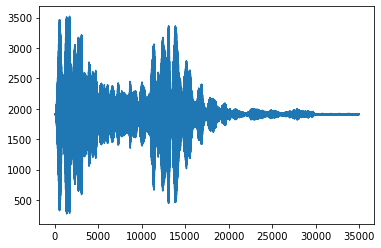

In [8]:
plt.plot(train_data_torch.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

# This is the formula for computing the size of the output of every layer

$$L_{out} = \frac{L_{in}- Kernel_{size}}{stride}+1$$

# Here there's and example: 
$input size = 1 * 20'000 * 4 $

after the first convolution:
$output = \frac{20000-5000}{5}+1 = 3001$
and the channels go from the initial 4 to the specified 32

after the second convolution:
$output = \frac{3001-2002}{1}+1 = 1000$
and the channels go from 32 to 64

after the last convolution:
$output = \frac{1000-1000}{1}+1 = 1$
and the channels go from 64 to 5 (as the number of classes!!!)




In [9]:
class fastCNN(nn.Module): 
    def __init__(self):
        super(fastCNN, self).__init__()
        self.conv = nn.Conv1d(numChannels, 2, kernel_size=5000, stride=2) 
        self.bn = nn.BatchNorm1d(2) #15001
        self.conv2 = nn.Conv1d(2, 2, kernel_size=5000, stride=2)
        self.bn2 = nn.BatchNorm1d(2) #5001
        self.conv3 = nn.Conv1d(2, 2, kernel_size=4500, stride=2)
        self.bn3 = nn.BatchNorm1d(2) #251
        self.conv4 = nn.Conv1d(2, numClasses, kernel_size=251)
                
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.view(-1, numClasses)
        return x

In [10]:
model, criterion = fastCNN(), nn.CrossEntropyLoss()

In [11]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(model)

49024

In [13]:
def compute_nb_errors(model, testing_generator):
    nb_errors=0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            predicted_classes = outputTest.max(1)[1]
            nb_errors += (predicted_classes != local_labels).long().sum()

    return nb_errors

In [14]:
if (torch.cuda.is_available()):
    model = model.cuda()

In [15]:
train_input = train_data_torch.view(train_data_torch.size(0), numChannels, -1).float()
train_target = train_targets_torch.long().view(-1)
test_input = test_data_torch.view(test_data_torch.size(0), numChannels, -1).float()
test_target = test_targets_torch.long().view(-1)

In [16]:
train_input.shape

torch.Size([6984, 1, 35000])

In [17]:
train_input = (train_input-torch.mean(train_input,2,keepdim=True))/(4096.0/2)
test_input = (test_input-torch.mean(test_input,2,keepdim=True))/(4096.0/2)

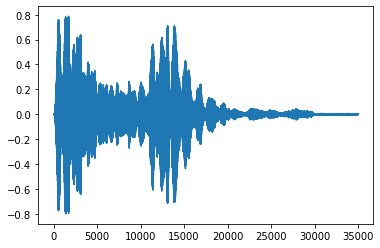

In [18]:
plt.plot(train_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

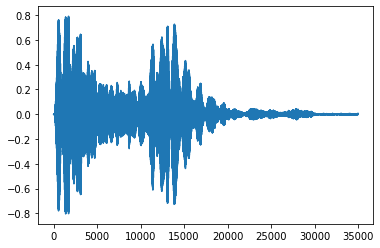

In [19]:
plt.plot(test_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

In [20]:
train_input.narrow(0, 0, 2).shape

torch.Size([2, 1, 35000])

In [21]:
out = model(train_input.narrow(0, 0, 2).cuda())
out.shape

torch.Size([2, 2])

In [22]:
lr = 3e-3

In [23]:
optimizer = optim.Adam(model.parameters(), lr = lr)
nb_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.2, patience = 30)

In [24]:
class errorsTable():
    def __init__(self):
        self.accuracyMatr = np.zeros((numClasses,numClasses))
    def newEntry(self,predictions,groundTruths):
        for pred,tru in zip(predictions,groundTruths):
            #print(pred, tru)
            self.accuracyMatr[pred,tru]+=1
    def getStats(self):
        #print(self.accuracyMatr)
        numEntry = np.sum(self.accuracyMatr,0)
        resultMatr = self.accuracyMatr/numEntry
        return resultMatr

In [25]:
np.set_printoptions(precision=2, suppress=True)

In [26]:
batch_size_train = 2000
batch_size_test = 1000

In [27]:
#torch.backends.cudnn.enabled = False

In [28]:
training_set = torch.utils.data.TensorDataset(train_input, train_target)
testing_set = torch.utils.data.TensorDataset(test_input, test_target)

In [29]:
# Generators
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, num_workers=0,
                                                shuffle=True, drop_last=True)
testing_generator = torch.utils.data.DataLoader(testing_set, batch_size=batch_size_test, num_workers=0,
                                                 shuffle=False, drop_last=False)

In [30]:
loss_train = []
loss_test = []

t = time.time()
for k in range (nb_epochs):
    
    # Create a new error table
    accuracyTRAIN = errorsTable()
    accuracyTEST = errorsTable()
    print('Epoch: ', k)
    model.train()

    lossValue = 0
    for local_batch, local_labels in training_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()       
        model.zero_grad()
        output = model(local_batch)
        accuracyTRAIN.newEntry(output.max(1)[1], local_labels)
        loss = criterion(output, local_labels)
        lossValue += loss.item()*local_batch.size(0)
        loss.backward()
        optimizer.step()
    scheduler.step(lossValue/train_input.size(0))
    print('Loss is ', lossValue/train_input.size(0))
    loss_train.append(lossValue/train_input.size(0))    
    ################################################################    
    model.eval()
    lossValue = 0 
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
            lossTest = criterion(outputTest, local_labels)
            lossValue += lossTest.item()*local_batch.size(0)
    print('Loss TEST is ', lossValue/test_input.size(0))
    loss_test.append(lossValue/test_input.size(0))
    print("")
    print("The accuracy in TEST is: ")
    print("  1    2    3   ")
    print(accuracyTEST.getStats())
    print("The accuracy in TRAIN is: ")
    print("  1    2    3   ")
    print(accuracyTRAIN.getStats())
    print("----------------------")
    if k%10 == 0:
        #nb_test_errors = compute_nb_errors(model, test_input, test_target, batch_size_test)

        #print(k, ': Test accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_test_errors) / test_input.size(0),
                                                     #nb_test_errors, test_input.size(0)))
        

        #nb_train_errors = compute_nb_errors(model, train_input, train_target, batch_size_train)

        #print(k, ': Train accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_train_errors) / train_input.size(0),
                                                          #nb_train_errors, train_input.size(0)))
        print("Hey! Ten epochs are passed! We are getting older")
        
        


nb_test_errors = compute_nb_errors(model, testing_generator)  
print('Final Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                  nb_test_errors, test_input.size(0)))

elapsed = time.time() - t
print(elapsed)

Epoch:  0
Loss is  0.8148159597064758
Loss TEST is  0.6838960280038071

The accuracy in TEST is: 
  1    2    3   
[[0. 0.]
 [1. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[0.42 0.66]
 [0.58 0.34]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  1
Loss is  0.5946427344729673
Loss TEST is  3.357088331907682

The accuracy in TEST is: 
  1    2    3   
[[0. 0.]
 [1. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[0.33 0.23]
 [0.67 0.77]]
----------------------
Epoch:  2
Loss is  0.5459243523432763
Loss TEST is  3.9459832886352504

The accuracy in TEST is: 
  1    2    3   
[[0. 0.]
 [1. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[0.33 0.12]
 [0.67 0.88]]
----------------------
Epoch:  3
Loss is  0.4653127401008912
Loss TEST is  8.12820600331886

The accuracy in TEST is: 
  1    2    3   
[[0. 0.]
 [1. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[0.74 0.33]
 [0.26 0.67]]
----------------------
Epoch:  4
Loss is  0.35750069671480106
Los

Loss TEST is  0.00011286518318919927

The accuracy in TEST is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
----------------------
Epoch:  36
Loss is  8.136856336736537e-05
Loss TEST is  0.00010932232720678616

The accuracy in TEST is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
----------------------
Epoch:  37
Loss is  7.763492822060884e-05
Loss TEST is  0.0001075533520120285

The accuracy in TEST is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
----------------------
Epoch:  38
Loss is  7.690644484236815e-05
Loss TEST is  0.00010461563747430784

The accuracy in TEST is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
The accuracy in TRAIN is: 
  1    2    3   
[[1. 0.]
 [0. 1.]]
----------------------
Epoch:  39
Loss is  8.636803178152417e-05
Loss TEST is  0.00010181656645452779

The accuracy in TEST is: 
  1    2    3   
[[1. 0.]

KeyboardInterrupt: 

In [31]:
accuracyTEST = errorsTable()

model.eval()
lossValue = 0 
with torch.set_grad_enabled(False):
    for local_batch, local_labels in testing_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
        outputTest = model(local_batch)
        accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
        lossTest = criterion(outputTest, local_labels)
        lossValue += lossTest.item()*local_batch.size(0)
print('Loss TEST is ', lossValue/test_input.size(0))

print("")
print("The accuracy in TEST is: ")
print("  1       2")
print(accuracyTEST.getStats())

Loss TEST is  8.612398348448893e-05

The accuracy in TEST is: 
  1       2
[[1. 0.]
 [0. 1.]]


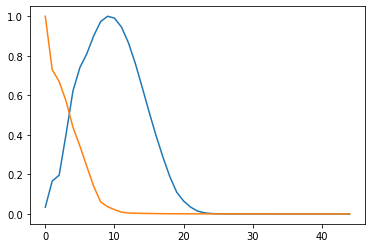

In [32]:
plt.figure()
plt.plot(np.array(loss_test)/max(loss_test))
plt.plot(np.array(loss_train)/max(loss_train))

In [33]:
torch.save(model, '../Models/model_wet')